In [1]:
from Clough_Toucher_derivation import *
import igl
import meshio as mio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import subprocess
import scipy
import h5py
from midpoint_constraint_validation import *

checking midpoint constraint for general cubic (should be zero):  0


In [2]:
def f0(x, y):
    return 1

def d0(x, y):
    return np.array([0, 0])

def f1(x, y):
    return x

def d1(x, y):
    return np.array([1, 0])

def f2(x, y):
    return x ** 2

def d2(x, y):
    return np.array([2 * x, 0])

def f3(x, y):
    return x ** 3 + y ** 2

def d3(x, y):
    return np.array([3 * x * x, 2 * y])

In [3]:
def build_boundary_data(_f, _d, _uv, _f_uv):
    boundary_data = []

    for fid in range(_f_uv.shape[0]):
        fv = _f_uv[fid]
        v0 = _uv[fv[0]]
        v1 = _uv[fv[1]]
        v2 = _uv[fv[2]]
        m0 = (v0 + v1) / 2.0
        m1 = (v1 + v2) / 2.0
        m2 = (v2 + v0) / 2.0

        e01 = v1 - v0
        e12 = v2 - v1
        e20 = v0 - v2

        em0 = v2 - m0
        em1 = v0 - m1
        em2 = v1 - m2

        f0 = _f(v0[0], v0[1])
        f1 = _f(v1[0], v1[1])
        f2 = _f(v2[0], v2[1])
        # print (f0)

        d0 = _d(v0[0], v0[1])
        d1 = _d(v1[0], v1[1])
        d2 = _d(v2[0], v2[1])
        # print(d0)
        
        dm0 = _d(m0[0], m0[1])
        dm1 = _d(m1[0], m1[1])
        dm2 = _d(m2[0], m2[1])

        d01 = d0 @ e01
        d10 = d1 @ (-e01)
        d12 = d1 @ e12
        d21 = d2 @ (-e12)
        d20 = d2 @ e20
        d02 = d0 @ (-e20)

        dm01 = dm0 @ em0
        dm12 = dm1 @ em1
        dm20 = dm2 @ em2

        bd = [f0,f1,f2, d01, d10, d12, d21, d20, d02, dm01, dm12, dm20]
        boundary_data.append(bd)

    print(len(boundary_data))
    return boundary_data

In [4]:
def build_boundary_data_3d(_F, _dF, _uv, _f_uv, _v, _f):
    boundary_data = []

    for fid in range(_f_uv.shape[0]):
        fv = _f[fid]
        v0 = _v[fv[0]]
        v1 = _v[fv[1]]
        v2 = _v[fv[2]]
        m0 = (v0 + v1) / 2.0
        m1 = (v1 + v2) / 2.0
        m2 = (v2 + v0) / 2.0

        f0 = _F(v0[0], v0[1])
        f1 = _F(v1[0], v1[1])
        f2 = _F(v2[0], v2[1])
        # print (f0)

        d0 = _dF(v0[0], v0[1])
        d1 = _dF(v1[0], v1[1])
        d2 = _dF(v2[0], v2[1])
        # print(d0)
        
        dm0 = _dF(m0[0], m0[1])
        dm1 = _dF(m1[0], m1[1])
        dm2 = _dF(m2[0], m2[1])

        fv_uv = _f_uv[fid]
        uv0 = _uv[fv_uv[0]]
        uv1 = _uv[fv_uv[1]]
        uv2 = _uv[fv_uv[2]]
        m0_uv = (uv0 + uv1) / 2.0
        m1_uv = (uv1 + uv2) / 2.0
        m2_uv = (uv2 + uv0) / 2.0
        
        e01 = uv1 - uv0
        e12 = uv2 - uv1
        e20 = uv0 - uv2

        em0 = uv2 - m0_uv
        em1 = uv0 - m1_uv
        em2 = uv1 - m2_uv

        d01 = d0 @ e01
        d10 = d1 @ (-e01)
        d12 = d1 @ e12
        d21 = d2 @ (-e12)
        d20 = d2 @ e20
        d02 = d0 @ (-e20)

        dm01 = dm0 @ em0
        dm12 = dm1 @ em1
        dm20 = dm2 @ em2

        bd = [f0,f1,f2, d01, d10, d12, d21, d20, d02, dm01, dm12, dm20]
        boundary_data.append(bd)

    print(len(boundary_data))
    return boundary_data

In [5]:
def generate_boundary_data(f, d, filename, uv, f_uv):
    f1_bd = build_boundary_data(f, d, uv, f_uv)
    with open(filename, "w") as file:
        for line in f1_bd:
            for value in line:
                file.write("{} ".format(value))
            file.write("\n")

def generate_boundary_data_3d(f, d, filename, uv, f_uv, _v, _f):
    f1_bd = build_boundary_data_3d(f, d, uv, f_uv, _v, _f)
    with open(filename, "w") as file:
        for line in f1_bd:
            for value in line:
                file.write("{} ".format(value))
            file.write("\n")


def check_constraint_matrice(ct_interp_file, interior_file, endpoint_file, midpoint_file, endpoint_elim_file):
    ct_interpolants = []
    with open(ct_interp_file, "r") as file:
        for line in file:
            value = float(line.split()[0])
            ct_interpolants.append(value)
    ct_interpolants = np.array(ct_interpolants)

    interior_matix = np.loadtxt(interior_file) 
    edge_end_point_matrix = np.loadtxt(endpoint_file) 
    edge_mid_point_matrix = np.loadtxt(midpoint_file) 
    edge_end_point_elim_matrix = np.loadtxt(endpoint_elim_file) 

    r1 = interior_matix @ ct_interpolants
    r2 = edge_end_point_matrix @ ct_interpolants
    r3 = edge_mid_point_matrix @ ct_interpolants
    r4 = edge_end_point_elim_matrix @ ct_interpolants

    print("interior constraint max: ", np.max(np.abs(r1)))
    print("interior constraint avg: ", np.average(np.abs(r1)))
    print("edge endpoint constraint max: ", np.max(np.abs(r2)))
    print("edge endpoint constraint avg: ", np.average(np.abs(r2)))
    print("edge midpoint constraint max: ", np.max(np.abs(r3)))
    print("edge midpoint constraint avg: ", np.average(np.abs(r3)))
    print("edge endpoint eliminated constraint max: ", np.max(np.abs(r4)))
    print("edge endpoint eliminated constraint avg: ", np.average(np.abs(r4)))

def get_P_G2E_mul_nodes(p_g2e_file, ct_interp_file):
    ct_interpolants = []
    with open(ct_interp_file, "r") as file:
        for line in file:
            value = float(line.split()[0])
            ct_interpolants.append(value)
    ct_interpolants = np.array(ct_interpolants)

    p_g2e = np.loadtxt(p_g2e_file)

    values = p_g2e @ ct_interpolants

    print(values)

def plot_ct_interpolant(ct_interp_file, ct_uv_file, f):
    ct_interpolants = []
    with open(ct_interp_file, "r") as file:
        for line in file:
            value = float(line.split()[0])
            ct_interpolants.append(value)
    ct_interpolants = np.array(ct_interpolants)

    ct_interpolants_uvs = []
    with open(ct_uv_file, "r") as file:
        for line in file:
            s = line.split()
            ct_interpolants_uvs.append([float(s[0]), float(s[1])])
    ct_interpolants_uvs = np.array(ct_interpolants_uvs)
    
    # Create a grid of x and y values
    X = ct_interpolants_uvs[:, 0]
    Y = ct_interpolants_uvs[:, 1]

    # get interpolants
    Z = ct_interpolants

    # compute real function values
    Z_real = []
    for i in range(X.shape[0]):
        Z_real.append(f(X[i], Y[i]))
    Z_real = np.array(Z_real)

    print("Z - Z_real max:", np.max(np.abs(Z-Z_real)))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the values
    ax.scatter(X, Y, Z, c = 'b', marker='o')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    plt.show()

In [26]:
build_path = '/Users/jiachengdai/Desktop/algebraic-contours/build/'

# mesh_file = "test_two_triangles.obj"
mesh_file = "test_eight_triangles.obj"
# mesh_file = "test_three_triangles.obj"

# mesh_file = "parameterized_tet.obj"
# mesh_file = "parameterized_icosphere.obj"
# mesh_file = "parameterized_tet_prob.obj"
v, uv, _, f, f_uv, _ = igl.read_obj(build_path + mesh_file)

In [27]:
# f1 d1
boundary_data_file = 'f1_boundary_data.txt'
output_name = "f1"

generate_boundary_data(f1, d1, "../../build/" + boundary_data_file, uv, f_uv)
# generate_boundary_data_3d(f1, d1, "../../build/" + boundary_data_file, uv, f_uv, v, f)
# generate_boundary_data_3d(f0, d0, "../../build/" + boundary_data_file, uv, f_uv, v, f)

build_path = '/Users/jiachengdai/Desktop/algebraic-contours/build/'
command = build_path + 'bin/generate_cubic_surface --input ' + build_path + mesh_file + ' -o ' + build_path + output_name + ' --boundary-data ' + build_path + boundary_data_file
subprocess.run(command.split(" "))

10
#Cone: 0
CHOLMOD warning: matrix not positive definite. file: /Users/jiachengdai/Desktop/algebraic-contours/build/_deps/suitesparse-src/CHOLMOD/Supernodal/t_cholmod_super_numeric.c line: 911
#F: 10
#E: 17
#V: 8
70 142
70 142
skip cnt: 8 v_cnt - cone_cnt: 8


CompletedProcess(args=['/Users/jiachengdai/Desktop/algebraic-contours/build/bin/generate_cubic_surface', '--input', '/Users/jiachengdai/Desktop/algebraic-contours/build/test_eight_triangles.obj', '-o', '/Users/jiachengdai/Desktop/algebraic-contours/build/f1', '--boundary-data', '/Users/jiachengdai/Desktop/algebraic-contours/build/f1_boundary_data.txt'], returncode=0)

In [28]:
command

'/Users/jiachengdai/Desktop/algebraic-contours/build/bin/generate_cubic_surface --input /Users/jiachengdai/Desktop/algebraic-contours/build/test_eight_triangles.obj -o /Users/jiachengdai/Desktop/algebraic-contours/build/f1 --boundary-data /Users/jiachengdai/Desktop/algebraic-contours/build/f1_boundary_data.txt'

interior constraint max:  1.5543122344752192e-15
interior constraint avg:  2.8102520310824275e-16
edge endpoint constraint max:  2.842170943040401e-14
edge endpoint constraint avg:  4.430007559043517e-15
edge midpoint constraint max:  7.105427357601002e-14
edge midpoint constraint avg:  1.0081804672147562e-14
edge endpoint eliminated constraint max:  2.842170943040401e-14
edge endpoint eliminated constraint avg:  4.218847493575595e-15
Z - Z_real max: 4.444444445139695e-06


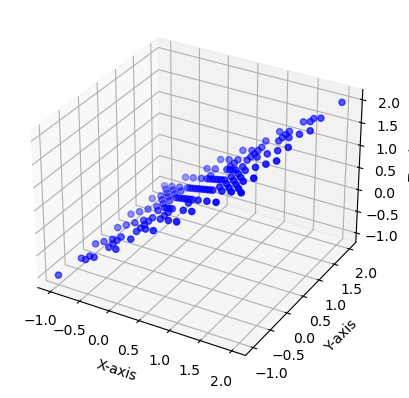

In [29]:
ct_interp_file = "../../build/f1_function_values_from_lagrange_nodes.txt"
ct_uv_file = "../../build/f1_function_values_from_lagrange_nodes_uvs.txt"
interior_file = '../../build/f1_interior_constraint_matrix.txt'
endpoint_file = '../../build/f1_edge_endpoint_constraint_matrix.txt'
midpoint_file = '../../build/f1_edge_midpoint_constraint_matrix.txt'
endpoint_elim_file = '../../build/f1_edge_endpoint_constraint_matrix_eliminated.txt'
check_constraint_matrice(ct_interp_file, interior_file, endpoint_file, midpoint_file, endpoint_elim_file)
plot_ct_interpolant(ct_interp_file, ct_uv_file, f1)

In [30]:
# f2
boundary_data_file = 'f2_boundary_data.txt'
output_name = "f2"

generate_boundary_data(f2, d2, "../../build/" + boundary_data_file, uv, f_uv)
build_path = '/Users/jiachengdai/Desktop/algebraic-contours/build/'
command = build_path + 'bin/generate_cubic_surface --input ' + build_path + mesh_file + ' -o ' + build_path + output_name + ' --boundary-data ' + build_path + boundary_data_file
subprocess.run(command.split(" "))

10
#Cone: 0
CHOLMOD warning: matrix not positive definite. file: /Users/jiachengdai/Desktop/algebraic-contours/build/_deps/suitesparse-src/CHOLMOD/Supernodal/t_cholmod_super_numeric.c line: 911
#F: 10
#E: 17
#V: 8
70 142
70 142
skip cnt: 8 v_cnt - cone_cnt: 8


CompletedProcess(args=['/Users/jiachengdai/Desktop/algebraic-contours/build/bin/generate_cubic_surface', '--input', '/Users/jiachengdai/Desktop/algebraic-contours/build/test_eight_triangles.obj', '-o', '/Users/jiachengdai/Desktop/algebraic-contours/build/f2', '--boundary-data', '/Users/jiachengdai/Desktop/algebraic-contours/build/f2_boundary_data.txt'], returncode=0)

In [31]:
ct_interp_file = "../../build/f2_function_values_from_lagrange_nodes.txt"
ct_uv_file = "../../build/f2_function_values_from_lagrange_nodes_uvs.txt"
interior_file = '../../build/f2_interior_constraint_matrix.txt'
endpoint_file = '../../build/f2_edge_endpoint_constraint_matrix.txt'
midpoint_file = '../../build/f2_edge_midpoint_constraint_matrix.txt'
endpoint_elim_file = '../../build/f2_edge_endpoint_constraint_matrix_eliminated.txt'
check_constraint_matrice(ct_interp_file, interior_file, endpoint_file, midpoint_file, endpoint_elim_file)
# plot_ct_interpolant(ct_interp_file, ct_uv_file, f2)

interior constraint max:  2.6645352591003757e-15
interior constraint avg:  3.487785457271083e-16
edge endpoint constraint max:  5.684341886080802e-14
edge endpoint constraint avg:  9.211585742551666e-15
edge midpoint constraint max:  7.105427357601002e-14
edge midpoint constraint avg:  9.431181326098849e-15
edge endpoint eliminated constraint max:  5.684341886080802e-14
edge endpoint eliminated constraint avg:  6.751010007432202e-15


In [32]:
# f3
boundary_data_file = 'f3_boundary_data.txt'
output_name = "f3"

generate_boundary_data(f3, d3, "../../build/" + boundary_data_file, uv, f_uv)
build_path = '/Users/jiachengdai/Desktop/algebraic-contours/build/'
command = build_path + 'bin/generate_cubic_surface --input ' + build_path + mesh_file + ' -o ' + build_path + output_name + ' --boundary-data ' + build_path + boundary_data_file
subprocess.run(command.split(" "))

10
#Cone: 0
CHOLMOD warning: matrix not positive definite. file: /Users/jiachengdai/Desktop/algebraic-contours/build/_deps/suitesparse-src/CHOLMOD/Supernodal/t_cholmod_super_numeric.c line: 911
#F: 10
#E: 17
#V: 8
70 142
70 142
skip cnt: 8 v_cnt - cone_cnt: 8


CompletedProcess(args=['/Users/jiachengdai/Desktop/algebraic-contours/build/bin/generate_cubic_surface', '--input', '/Users/jiachengdai/Desktop/algebraic-contours/build/test_eight_triangles.obj', '-o', '/Users/jiachengdai/Desktop/algebraic-contours/build/f3', '--boundary-data', '/Users/jiachengdai/Desktop/algebraic-contours/build/f3_boundary_data.txt'], returncode=0)

In [33]:
command

'/Users/jiachengdai/Desktop/algebraic-contours/build/bin/generate_cubic_surface --input /Users/jiachengdai/Desktop/algebraic-contours/build/test_eight_triangles.obj -o /Users/jiachengdai/Desktop/algebraic-contours/build/f3 --boundary-data /Users/jiachengdai/Desktop/algebraic-contours/build/f3_boundary_data.txt'

In [34]:
ct_interp_file = "../../build/f3_function_values_from_lagrange_nodes.txt"
ct_uv_file = "../../build/f3_function_values_from_lagrange_nodes_uvs.txt"
interior_file = '../../build/f3_interior_constraint_matrix.txt'
endpoint_file = '../../build/f3_edge_endpoint_constraint_matrix.txt'
midpoint_file = '../../build/f3_edge_midpoint_constraint_matrix.txt'
endpoint_elim_file = '../../build/f3_edge_endpoint_constraint_matrix_eliminated.txt'
check_constraint_matrice(ct_interp_file, interior_file, endpoint_file, midpoint_file, endpoint_elim_file)
# plot_ct_interpolant(ct_interp_file, ct_uv_file, f3)

interior constraint max:  5.440092820663267e-15
interior constraint avg:  8.145270172629385e-16
edge endpoint constraint max:  1.1368683772161603e-13
edge endpoint constraint avg:  1.6189663988504487e-14
edge midpoint constraint max:  1.8474111129762605e-13
edge midpoint constraint avg:  2.3543258845727585e-14
edge endpoint eliminated constraint max:  1.1368683772161603e-13
edge endpoint eliminated constraint avg:  1.4027240907283227e-14


In [35]:
# test on tet mesh

interior_matix = np.loadtxt('../../build/tet_interior_constraint_matrix.txt') 
edge_end_point_matrix = np.loadtxt('../../build/tet_edge_endpoint_constraint_matrix.txt') 
edge_mid_point_matrix = np.loadtxt('../../build/tet_edge_midpoint_constraint_matrix.txt')

tet_mesh = mio.read("../../build/tet_from_lagrange_nodes.msh")
tet_points = tet_mesh.points


# interior_matix = np.loadtxt('../../build/tet_prob_interior_constraint_matrix.txt') 
# edge_end_point_matrix = np.loadtxt('../../build/tet_prob_edge_endpoint_constraint_matrix.txt') 
# edge_mid_point_matrix = np.loadtxt('../../build/tet_prob_edge_midpoint_constraint_matrix.txt')

# tet_mesh = mio.read("../../build/tet_prob_from_lagrange_nodes.msh")
# tet_points = tet_mesh.points

r1 = interior_matix @ tet_points
r2 = edge_end_point_matrix @ tet_points
r3 = edge_mid_point_matrix @ tet_points

print("interior constraint max: ", np.max(np.abs(r1)))
print("interior constraint avg: ", np.average(np.abs(r1)))
print("edge endpoint constraint max: ", np.max(np.abs(r2)))
print("edge endpoint constraint avg: ", np.average(np.abs(r2)))
print("edge midpoint constraint max: ", np.max(np.abs(r3)))
print("edge midpoint constraint avg: ", np.average(np.abs(r3)))

print(r3)


interior constraint max:  1.2437651242258596e-08
interior constraint avg:  1.7670096222861742e-09
edge endpoint constraint max:  4.814427279481448e-07
edge endpoint constraint avg:  1.596111247071282e-07
edge midpoint constraint max:  1.2202906751763446e-06
edge midpoint constraint avg:  2.0372468011018671e-07
[[-4.03009643e-13 -5.77780934e-07  5.77781404e-07]
 [ 8.18714264e-09 -2.58335052e-08  2.73438317e-10]
 [-8.52467263e-08  4.19793015e-07 -1.53654517e-07]
 [ 2.57790970e-07 -5.45282040e-08 -1.15062469e-07]
 [-4.38800260e-10 -4.22815300e-08  9.67102562e-09]
 [-1.55006199e-08  1.22029068e-06  1.02928862e-07]]


In [7]:
# test on tet mesh

interior_matix = scipy.io.mmread('../../build/icosphere_interior_constraint_matrix.txt') 
edge_end_point_matrix = scipy.io.mmread('../../build/icosphere_edge_endpoint_constraint_matrix.txt') 
edge_mid_point_matrix = scipy.io.mmread('../../build/icosphere_edge_midpoint_constraint_matrix.txt')

ico_sphere_mesh = mio.read("../../build/icosphere_from_lagrange_nodes.msh")
ico_points = ico_sphere_mesh.points

local2global = []
idx = 0
# with open("../../build/icosphere_surface_tri_to_tet_v_map.txt", "r") as file:
#     for line in file:
#         local2global.append(int(line))
#         idx += 1

with open("../../build/icosphere_surface_correct_tri_to_tet_v_map.txt", "r") as file:
    for line in file:
        local2global.append(int(line))
        idx += 1

tetmesh = mio.read("../../build/test_curved_high_order_tetmesh.msh")
surface_mesh = mio.read("../../build/icosphere_from_lagrange_nodes.msh")

s_points = surface_mesh.points
t_points = tetmesh.points

t_s_points = t_points[local2global]

t_s_points_2 = []
for i in local2global:
    t_s_points_2.append(t_points[i])
t_s_points_2 = np.array(t_s_points_2)

# r1 = interior_matix @ ico_points
# r2 = edge_end_point_matrix @ ico_points
# r3 = edge_mid_point_matrix @ ico_points

r1 = interior_matix @ ico_points
r2 = edge_end_point_matrix @ ico_points
r3 = edge_mid_point_matrix @ ico_points

print("interior constraint max: ", np.max(np.abs(r1)))
print("interior constraint avg: ", np.average(np.abs(r1)))
print("edge endpoint constraint max: ", np.max(np.abs(r2)))
print("edge endpoint constraint avg: ", np.average(np.abs(r2)))
print("edge midpoint constraint max: ", np.max(np.abs(r3)))
print("edge midpoint constraint avg: ", np.average(np.abs(r3)))

print(r2)




interior constraint max:  6.661338147750939e-16
interior constraint avg:  1.1946609030891232e-16
edge endpoint constraint max:  1.0658141036401503e-14
edge endpoint constraint avg:  1.4325659302118325e-15
edge midpoint constraint max:  2.3092638912203256e-14
edge midpoint constraint avg:  3.046120213706649e-15
[[-8.88178420e-16  1.33226763e-15  4.44089210e-16]
 [-8.88178420e-16  2.66453526e-15  2.22044605e-16]
 [ 0.00000000e+00 -3.55271368e-15  1.11022302e-15]
 ...
 [ 8.88178420e-16  1.11022302e-15 -8.88178420e-16]
 [-4.44089210e-16  4.44089210e-16 -8.88178420e-16]
 [ 2.66453526e-15  1.33226763e-15 -8.88178420e-16]]


In [9]:
ico_points

array([[-0.64260911,  0.6650377 ,  0.15773209],
       [-0.7786502 ,  0.470781  ,  0.0203965 ],
       [-0.62738648,  0.64040258, -0.18857649],
       ...,
       [-0.67794155, -0.41380598, -0.54916393],
       [-0.71693529, -0.32936229, -0.53387218],
       [-0.76601034, -0.22127783, -0.52258452]])

In [42]:
# interior_matix = np.loadtxt('../../build/tet_interior_constraint_matrix.txt') 
# edge_end_point_matrix = np.loadtxt('../../build/tet_edge_endpoint_constraint_matrix.txt') 
# edge_mid_point_matrix = np.loadtxt('../../build/tet_edge_midpoint_constraint_matrix.txt')
# edge_end_point_matrix_elim = np.loadtxt('../../build/tet_edge_endpoint_constraint_matrix_eliminated.txt') 

# t_mesh = mio.read("../../build/tet_from_lagrange_nodes.msh")
# t_points = t_mesh.points

interior_matix = np.loadtxt('../../build/icosphere_interior_constraint_matrix.txt') 
edge_end_point_matrix = np.loadtxt('../../build/icosphere_edge_endpoint_constraint_matrix.txt') 
edge_mid_point_matrix = np.loadtxt('../../build/icosphere_edge_midpoint_constraint_matrix.txt')
edge_end_point_matrix_elim = np.loadtxt('../../build/icosphere_edge_endpoint_constraint_matrix_eliminated.txt') 

t_mesh = mio.read("../../build/icosphere_from_lagrange_nodes.msh")
t_points = t_mesh.points

# big_matrix = np.concatenate((interior_matix,edge_end_point_matrix_elim, edge_mid_point_matrix))

# b = - (big_matrix @ t_points)

# r, _, _, _ = np.linalg.lstsq(big_matrix, b, rcond=None)
# # r, res, rang, s = np.linalg.lstsq(cM.T, cv.flatten(), rcond=None)

# t_new = t_points + r

# print(np.linalg.norm(big_matrix @ t_new))

# mesh_new = mio.Mesh(t_new, t_mesh.cells)
# mesh_new.write("tet_lsq.msh", file_format='gmsh')

# int_rank = np.linalg.matrix_rank(interior_matix)
end_rank = np.linalg.matrix_rank(edge_end_point_matrix)
end_rank_elim = np.linalg.matrix_rank(edge_end_point_matrix_elim)
mid_rank = np.linalg.matrix_rank(edge_mid_point_matrix)


print(np.max(np.abs(interior_matix @ t_points)))
print(np.max(np.abs(edge_end_point_matrix @ t_points)))
print(np.max(np.abs(edge_mid_point_matrix @ t_points)))
# # print(edge_mid_point_matrix @ t_points)

# print(interior_matix.shape[0], int_rank)
print(edge_end_point_matrix.shape[0], end_rank)
print(edge_end_point_matrix_elim.shape[0], end_rank_elim)
print(edge_mid_point_matrix.shape[0], mid_rank)

# end_res = edge_end_point_matrix @ t_points
# for i in range((end_res).shape[0]//2):
#     print(i, ": ", end_res[2*i], end_res[2*i+1])
    
# mid_res = edge_mid_point_matrix @ t_points
# for i in range((mid_res).shape[0]):
#     print(i, ": ", mid_res[i])


7.216449660063518e-16
1.887379141862766e-14
2.6645352591003757e-14
384 268
326 268
192 192


In [39]:
# write matrix
big_mesh = np.concatenate((interior_matix, edge_end_point_matrix_elim, edge_mid_point_matrix))

local2global = np.loadtxt("../../build/icosphere_surface_correct_tri_to_tet_v_map.txt").astype(np.int32)
A = big_mesh
m = mio.read("../../build/test_linear_high_order_tetmesh.msh")
v = m.points
b = -(A @ v[local2global, :])

# print(A.shape)
# print(local2global.shape)
# print(b.shape)

with h5py.File("3dc_good.hdf5", 'w') as f:
    f.create_dataset("local2global", data=local2global.astype(np.int32))
    f.create_dataset("A", data=A)
    f.create_dataset("b", data=b)

In [95]:
miss_match_cnt = 0
for i in range((s_points - t_s_points_2).shape[0]):
    if abs((s_points - t_s_points_2)[i][0]) > 1e-10:
        # print((s_points - t_s_points_2)[i])
        miss_match_cnt += 1

In [66]:
interior_matix = np.loadtxt('../../build/icosphere_interior_constraint_matrix.txt') 
edge_end_point_matrix = np.loadtxt('../../build/icosphere_edge_endpoint_constraint_matrix.txt') 
edge_mid_point_matrix = np.loadtxt('../../build/icosphere_edge_midpoint_constraint_matrix.txt')
edge_end_point_matrix_elim = np.loadtxt('../../build/icosphere_edge_endpoint_constraint_matrix_eliminated.txt') 

big_mesh = np.concatenate((interior_matix, edge_end_point_matrix_elim, edge_mid_point_matrix))

In [77]:
q, r  = scipy.linalg.qr(big_mesh.T)

In [78]:
r.shape

(1730, 1414)

In [81]:
np.sum(r[1413])

25.65571072893227

In [70]:
np.sum(r, axis=1)

array([ 8.21565038e-15, -7.10542736e-15,  1.91513472e-15, ...,
       -6.43929354e-15, -1.50435220e-14, -5.44009282e-15])

In [102]:
q_rank = np.linalg.matrix_rank(q)
r_rank = np.linalg.matrix_rank(r)

In [109]:
A_rank = np.linalg.matrix_rank(big_mesh)

In [111]:
ico_sphere_mesh = mio.read("../../build/icosphere_from_lagrange_nodes.msh")
ico_points = ico_sphere_mesh.points

In [114]:
print(np.max(np.abs(interior_matix @ ico_points)))
print(np.max(np.abs(edge_end_point_matrix_elim @ ico_points)))
# print(edge_mid_point_matrix)
print(np.max(np.abs(edge_mid_point_matrix @ ico_points)))

print(np.max(np.abs(big_mesh @ ico_points)))

2.553134779981203e-09
1.140895445855157
0.20010132890498866
1.140895445855157


In [ ]:
with np.printoptions(threshold=np.inf):
    print(np.linalg.norm(big_mesh, axis=0))

In [ ]:
print(interior_matix.shape)
print(edge_end_point_matrix.shape)
print(edge_end_point_matrix_elim.shape)
print(edge_mid_point_matrix.shape)
print(big_mesh.shape)

(896, 1730)
(384, 1730)
(326, 1730)
(192, 1730)
(1414, 1730)


In [ ]:
import h5py

local2global = np.loadtxt("../../build/icosphere_surface_correct_tri_to_tet_v_map.txt").astype(np.int32)
A = big_mesh
m = mio.read("../../build/test_linear_high_order_tetmesh.msh")
v = m.points
b = -(A @ v[local2global, :])

print(A.shape)
print(local2global.shape)
print(b.shape)

with h5py.File("3dc__aaaaa.hdf5", 'w') as f:
    f.create_dataset("local2global", data=local2global.astype(np.int32))
    f.create_dataset("A", data=A)
    f.create_dataset("b", data=b)


(1414, 1730)
(1730,)
(1414, 3)


In [ ]:
get_P_G2E_mul_nodes("../../build/P_G2E.txt", "../../build/f1_function_values_from_lagrange_nodes.txt")

[0.         1.         0.         0.33333333 0.66666667 0.66666667
 0.33333333 0.         0.         0.44444444 0.44444444 0.11111111
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.         0.         0.33333333 0.66666667 0.66666667
 0.33333333 0.         0.         0.44444444 0.44444444 0.11111111
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.66666667 0.33333333 0.
 0.         0.33333333 0.66666667 0.44444444 0.11111111 0.44444444
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.66666667 0.33333333 0.
 0.         0.33333333 0.66666667 0.44444444 0.11111111 0.44444444
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.     

In [2]:
from midpoint_constraint_validation import *

checking midpoint constraint for general cubic (should be zero):  0


In [ ]:
TT = list(np.array([[0,0], [0,3], [-1,0]]))
TT_p = list(np.array([[0,3], [0,0], [1,0]]))

g_m = compute_gm(T)
g_m_prime = compute_gm(Tp)


In [ ]:
g_m_0 = compute_gm(TT)
g_m_1 = compute_gm(TT_p)

In [9]:
c_e = generate_ce(polys_C1_f)
c_e = npa(c_e) 
ch = npa([0,0,0,0,1])

def compute_gm_test(T):
    u01 = T[1]-T[0] 
    u10 = T[0]-T[1]
    # print("u01:", u01)
    
    mpt = (T[0]+T[1])/2 
    m   =  T[2]-mpt
    # print("m:", m)
    u01_n = u01/norm2(u01); u10_n = u10/norm2(u10); 
    # print("u01_n:", u01_n)
    # print("u01_n_prep: ", perp(u01_n))
    gm =  (ch - np.dot(m, u01_n)*c_e/norm2(u01))/np.dot(m, perp(u01_n));
    # print("np.dot(m, u01_n): ", np.dot(m, u01_n))
    # print(norm2(u01))
    # print("ch - np.dot(m, u01_n)*c_e/norm2(u01): ", ch - np.dot(m, u01_n)*c_e/norm2(u01))
    # print("yy: ", np.dot(m, perp(u01_n)))
    return gm

In [63]:
# pp = np.array([[0, 0],
# [0.87310264093377665, 0.87310264093377654],
# [0.43655132046688805, -0.81779020462853524],
# [-0.81779020462853447, 0.43655132046688827],
# [-0.4365513204668886, -0.8177902046285348],
# [1.309653961400665, -0.8177902046285348]])

# vt 0 0
# vt 0.87310264093377665 0.87310264093377654
# vt 0.43655132046688805 -0.81779020462853524
# vt -0.81779020462853447 0.43655132046688827

pp_2 = np.array([[0, 0],
[0.87310264093377665, 0.87310264093377654],
[0.43655132046688805, -0.81779020462853524],
[-0.81779020462853447, 0.43655132046688827]
])

pp = np.array([[-0.5, 0],
[0.5, 0],
[-0.7183242074230329, -0.7183242074230325],
[-0.7183242074230323,  0.7183242074230326]
])

TT = list(np.array([pp[0], pp[1], pp[3]]))
compute_gm_test(TT)

u01: [1. 0.]
m: [-0.71832421  0.71832421]
u01_n: [1.00000000000000 0]
u01_n_prep:  [0, 1.00000000000000]
np.dot(m, u01_n):  -0.718324207423032
1.00000000000000
ch - np.dot(m, u01_n)*c_e/norm2(u01):  [-1.07748631113455 1.07748631113455 -0.179581051855758 0.179581051855758 1]
yy:  0.718324207423033


array([-1.50000000000000, 1.50000000000000, -0.250000000000000,
       0.250000000000000, 1.39212905491167], dtype=object)

In [64]:
TT_2 = list(np.array([pp_2[0], pp_2[1], pp_2[3]]))
gm = compute_gm_test(TT_2)

u01: [0.87310264 0.87310264]
m: [-1.25434153  0.        ]
u01_n: [0.707106781186548 0.707106781186547]
u01_n_prep:  [-0.707106781186547, 0.707106781186548]
np.dot(m, u01_n):  -0.886953398318850
1.23475359615231
ch - np.dot(m, u01_n)*c_e/norm2(u01):  [-1.07748631113455 1.07748631113455 -0.179581051855758 0.179581051855758 1]
yy:  0.886953398318849


In [65]:
rdm = np.array([0.07265181092348216,  0.9869807651025245,  0.8949478612243169, -0.9467975711355811, -0.6520840786817188])
gm.dot(rdm)

0.00264982504254840

In [11]:
# x^2
pp = np.array([[0, 0 ],
[1, 0],
[0.3, 1],
[0, -1]
])

pp_e_chart = np.array([[0.5, 0 ],
[-0.5, 0], 
[0.2, -1],
[0.5, 1]
])

TT = list(np.array([pp[1], pp[0], pp[3]]))
TT_p = list(np.array([pp[0], pp[1], pp[2]]))

TT_e = list(np.array([pp_e_chart[1], pp_e_chart[0], pp_e_chart[3]]))
TT_p_e = list(np.array([pp_e_chart[0], pp_e_chart[1], pp_e_chart[2]]))

gm_e = compute_gm_test(TT_e)
gm_e_p = compute_gm_test(TT_p_e)

gm = compute_gm_test(TT)
gm_p = compute_gm_test(TT_p)

r_dM_x =   np.array( [ 1.000000000000003, -3.234031308186142e-15,     -1.000000000000005,      1.000000000000005,    -0.5000000000000022])
r_dM_x_prime = np.array([-3.234031308186142e-15,      1.000000000000003,      1.000000000000005,     -1.000000000000005,    -0.2000000000000027])

r_dM_y = np.array([ -1.477810214497488e-15,  2.160231850389962e-15,  3.008410920660721e-15, -4.033905291097418e-15 ,    -1.000000000000006])
r_dM_y_prime = np.array([ 2.160231850389962e-15, -1.477810214497488e-15, -4.033905291097418e-15,  3.008410920660721e-15,     1.000000000000008])

r_dM_z =   np.array([0.994613543550971, -0.03052325321117394 ,  -1.029531058129769,    1.019579880513667 , -0.3988167817076487])
r_dM_z_prime =np.array([ -0.03052325321117394,    0.994613543550971 ,   1.019579880513667,   -1.029531058129769,  -0.3191859052341521])

print("using e chart uv:")
print("gm_e: ", gm_e)
print("gm_e': ", gm_e_p)
print(gm_e.dot(r_dM_x) + gm_e_p.dot(r_dM_x_prime))
print(gm_e.dot(r_dM_y) + gm_e_p.dot(r_dM_y_prime))
print(gm_e.dot(r_dM_z) + gm_e_p.dot(r_dM_z_prime))
print("using global uv:")
print("gm: ", gm)
print("gm'': ", gm_p)
print(gm.dot(r_dM_x) + gm_p.dot(r_dM_x_prime))
print(gm.dot(r_dM_y) + gm_p.dot(r_dM_y_prime))
print(gm.dot(r_dM_z) + gm_p.dot(r_dM_z_prime))


using e chart uv:
gm_e:  [0.750000000000000 -0.750000000000000 0.125000000000000 -0.125000000000000
 1.00000000000000]
gm_e':  [-0.300000000000000 0.300000000000000 -0.0500000000000000
 0.0500000000000000 1.00000000000000]
-8.32667268468867e-17
-4.44089209850063e-16
-0.000203464604149994
using global uv:
gm:  [0.750000000000000 -0.750000000000000 0.125000000000000 -0.125000000000000
 1.00000000000000]
gm'':  [-0.300000000000000 0.300000000000000 -0.0500000000000000
 0.0500000000000000 1.00000000000000]
-8.32667268468867e-17
-4.44089209850063e-16
-0.000203464604149994


In [48]:
m= scipy.io.mmread("../../build/icosphere__interior_constraint_matrix.txt")

In [52]:

full_matrix = scipy.sparse.hstack((m, m, m))

In [53]:
full_matrix.shape

(896, 5190)

In [54]:
full_matrix

<896x5190 sparse matrix of type '<class 'numpy.float64'>'
	with 51072 stored elements in COOrdinate format>

In [57]:
polyfem_mesh = mio.read("../../build/test_pipeline_icosphere/"+ 'icosphere_final.vtu')

In [63]:
a = np.array([i for i in range(len(polyfem_mesh.cells[0]))])

In [64]:
polyfem_mesh.cell_data['winding'] = a[:,None]

In [65]:
polyfem_mesh.write("tagged.vtu")

In [107]:
interior_matix = scipy.io.mmread('../../build/icosphere_interior_constraint_matrix.txt') 
edge_end_point_matrix = scipy.io.mmread('../../build/icosphere_edge_endpoint_constraint_matrix.txt') 
edge_end_point_matrix_elim = scipy.io.mmread('../../build/icosphere_edge_endpoint_constraint_matrix_eliminated.txt') 
edge_mid_point_matrix = scipy.io.mmread('../../build/icosphere_edge_midpoint_constraint_matrix.txt')

full_matrix = scipy.sparse.vstack((interior_matix, edge_end_point_matrix, edge_mid_point_matrix))


In [108]:
q, r = scipy.linalg.qr(edge_end_point_matrix_elim.T.todense())
print(np.linalg.matrix_rank(r))
print(r.shape)

268
(1730, 326)


In [110]:
edge_end_point_matrix.shape

(384, 1730)

In [101]:
q, r = scipy.linalg.qr(full_matrix.T.todense())
print(np.linalg.matrix_rank(r))
print(r.shape)

1356
(1730, 1414)


In [105]:
r_rows = np.sum(r, axis=1)

In [106]:
r_rows.shape

(1730,)

In [89]:
local2global = np.loadtxt("../../build/icosphere_surface_correct_tri_to_tet_v_map.txt").astype(np.int32)

In [90]:
len(local2global)

1730

In [91]:
len(np.unique(local2global))

1730

In [2]:
ct = generate_ct(polys_C1_f)

In [3]:
ct

[[[-3, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
  [3, -3, 0, 0, -1/2, -1, 0, 0, 0, 4, 0, 0],
  [-3, -3/2, 9/2, 0, -5/4, 3/2, -1/2, 7/4, 0, -6, 0, 2]],
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[-3, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0],
  [3, 0, -3, 0, 0, 0, -1, -1/2, 0, 0, 0, 4],
  [-3, 9/2, -3/2, 0, 7/4, -1/2, 3/2, -5/4, 0, 2, 0, -6]]]

In [4]:
ct.shape

AttributeError: 'list' object has no attribute 'shape'